# Eval WEAC

Initialize models, run over a resolution of 5cm with a standardized weak layer.


In [30]:
# Auto reload modules
%load_ext autoreload
%autoreload all

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import os
from typing import List
import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
from pprint import pprint
import copy
from tqdm.notebook import tqdm

from weac_2.analysis import Analyzer, CriteriaEvaluator, CoupledCriterionResult, SSERRResult
from weac_2.core.system_model import SystemModel
from weac_2.components import ModelInput, Segment, ScenarioConfig, WeakLayer, Layer, CriteriaConfig
from weac_2.utils.snowpilot_parser import SnowPilotParser, convert_to_mm, convert_to_deg

In [32]:
number_of_files = 1

# Process multiple files
file_paths = []
for directory in os.listdir("data/snowpits"):
    for file in os.listdir(f"data/snowpits/{directory}"):
        if file.endswith(".xml"):
            file_paths.append(f"data/snowpits/{directory}/{file}")

paths: List[str] = []
parsers: List[SnowPilotParser] = []

for file_path in file_paths[:number_of_files]:
    snowpilot_parser = SnowPilotParser(file_path)
    paths.append(file_path)
    parsers.append(snowpilot_parser)

print(f"\nFound {len(paths)} files")


Found 1 files


In [33]:
# Setup standard values
wl_spacing = 50 # mm
phi = 0.0
standard_scenario_config = ScenarioConfig(system_type="skier", phi=phi)
standard_weak_layer = WeakLayer(rho=125, h=20, E=1.0, sigma_c=5.16, tau_c=4.09)
standard_segments = [
    Segment(length=10000, has_foundation=True, m=0.0),
    Segment(
        length=10000,
        has_foundation=True,
        m=0.0,
    ),
]
standard_criteria_config = CriteriaConfig()
standard_criteria_evaluator = CriteriaEvaluator(standard_criteria_config)

In [34]:
from weac.tools import touchdown_distance

# Collect errors
error_paths = {}
error_values = {}

paths = paths[:1]
parsers = parsers[:1]

data_rows = []
for i, (file_path, parser) in tqdm(
    enumerate(zip(paths, parsers)), total=len(paths), desc="Processing files"
):    
    # Extract layers
    layers, density_method = parser.extract_layers()
    print("layers: ", layers)
    # # TRIAL: make whole layering 6m deep
    # heights = np.cumsum([layer.h for layer in layers])
    # layers[-1].h = 2500 - heights[-2]
    heights = np.cumsum([layer.h for layer in layers])
    # space evenly and append the last height
    wl_depths = np.arange(wl_spacing, heights[-1], wl_spacing).tolist()
    wl_depths.append(heights[-1])
    
    # # Only look at depths where weak layer is 2500mm deep
    # wl_depths = [depth for depth in wl_depths if depth > 2000]
    
    layers_copy = copy.deepcopy(layers)
    for i, wl_depth in tqdm(enumerate(wl_depths), total=len(wl_depths), desc="Processing weak layers", leave=False):
        # only keep layers above the spacing
        mask = heights <= wl_depth
        new_layers = [layer for layer, keep in zip(layers_copy, mask) if keep]
        # Add truncated layer if needed
        depth = np.sum([layer.h for layer in new_layers]) if new_layers else 0.0
        if depth < wl_depth:
            additional_layer = copy.deepcopy(layers_copy[len(new_layers) if new_layers else 0])
            additional_layer.h = wl_depth - depth
            new_layers.append(additional_layer)
        
        if i >= len(wl_depths) - 2:
            print("new_layer heights: ", [layer.h for layer in new_layers])
            print("wl_depth: ", wl_depth)
            print("new_layers: ", new_layers)
        
        model_input = ModelInput(
            weak_layer=standard_weak_layer,
            layers=new_layers,
            scenario_config=standard_scenario_config,
            segments=standard_segments,
        )
        system = SystemModel(model_input=model_input)
        
        cc_result: CoupledCriterionResult = standard_criteria_evaluator.evaluate_coupled_criterion(system, print_call_stats=True)

        # Setup the scenario with the touchdown distance
        # TODO: Bug in Vertical SSERR
        sserr_result: SSERRResult = standard_criteria_evaluator.evaluate_SSERR(system, vertical=False)

        breakpoint()
        
        # # Generate old weac layers from layers
        # layers = [
        #     [layer.rho, layer.h] for layer in new_layers
        # ]
        # touchdown_distances = touchdown_distance(layers=layers, phi=phi, Ewl=1.0, t=20, vertical=False)
        # print("Touchdown distance old weac: ", touchdown_distances)
        # breakpoint()

        print("\nwl_depth: ", wl_depth)
        print("ImpactCriterion: ", cc_result.initial_critical_skier_weight)
        print("CoupledCriterion: ", cc_result.critical_skier_weight)
        print("Touchdown distance: ", sserr_result.touchdown_distance)
        print("SSERR: ", sserr_result.SSERR)
        data_rows.append({
            "wl_depth": wl_depth,
            "impact_criterion": cc_result.initial_critical_skier_weight,
            "coupled_criterion": cc_result.critical_skier_weight,
            "sserr_result": sserr_result.SSERR,
            "touchdown_distance": sserr_result.touchdown_distance,
        })

plot_layers = layers
plot_weaklayer = standard_weak_layer


Processing files:   0%|          | 0/1 [00:00<?, ?it/s]

layers:  [Layer(rho=101.0, h=100.0, nu=0.25, E=0.3963944665536936, G=0.15855778662147743, tensile_strength=1.103877672602255, tensile_strength_method='sigrist', E_method='bergfeld', grain_type='DF', grain_size=None, hand_hardness='F'), Layer(rho=173.0, h=170.0, nu=0.25, E=4.231714820461142, G=1.6926859281844568, tensile_strength=4.1040183019389715, tensile_strength_method='sigrist', E_method='bergfeld', grain_type='DF', grain_size=None, hand_hardness='1F'), Layer(rho=137.0, h=30.0, nu=0.25, E=1.515947056821604, G=0.6063788227286416, tensile_strength=2.3226029915382136, tensile_strength_method='sigrist', E_method='bergfeld', grain_type='DF', grain_size=None, hand_hardness='4F'), Layer(rho=209.0, h=300.0, nu=0.25, E=9.722035388607377, G=3.888814155442951, tensile_strength=6.509291720550219, tensile_strength_method='sigrist', E_method='bergfeld', grain_type='DF', grain_size=None, hand_hardness='P'), Layer(rho=163.7, h=20.0, nu=0.25, E=3.318392308727041, G=1.3273569234908165, tensile_stren

Processing weak layers:   0%|          | 0/60 [00:00<?, ?it/s]

skier_weight:  0.0
skier_weight:  300.0
skier_weight:  0.3833621036870978
skier_weight:  150.19168105184355
skier_weight:  1.1452221954307369
skier_weight:  66.89661499163618
skier_weight:  2.8094452520050845
skier_weight:  27.93151754442327
skier_weight:  6.25764937290583
skier_weight:  13.52146858231281
skier_weight:  10.000274801039712
skier_weight:  10.556060966777528
skier_weight:  10.633684636007157
skier_weight:  10.631184636007152
--- find_minimum_force Call Statistics ---
- rasterize_solution: called 16 times, total time 0.7053s, avg time 0.0441s
---------------------------------
--- evaluate_coupled_criterion Call Statistics ---
- rasterize_solution: called 12 times, total time 0.4918s, avg time 0.0410s
- incremental_ERR: called 13 times, total time 0.0570s, avg time 0.0044s
---------------------------------

wl_depth:  50.0
ImpactCriterion:  10.633684636007157
CoupledCriterion:  17.144713622886936
Touchdown distance:  491.8049937756792
SSERR:  0.9953467633129917
skier_weight

In [35]:
from plotly_snow_profile import snow_profile

In [36]:
import pandas as pd

dataframe = pd.DataFrame(data_rows)
snow_profile(weaklayer=plot_weaklayer, layers=plot_layers, dataframe=dataframe)

In [37]:
from plotly_snow_profile import snow_profile_with_data

snow_profile_with_data(plot_weaklayer, plot_layers, dataframe)

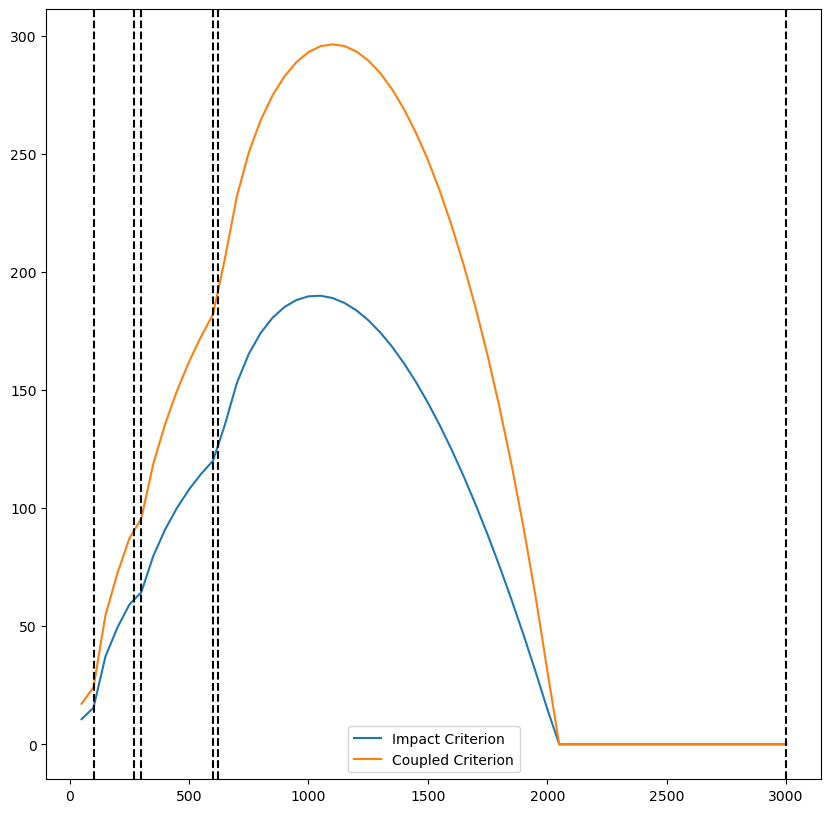

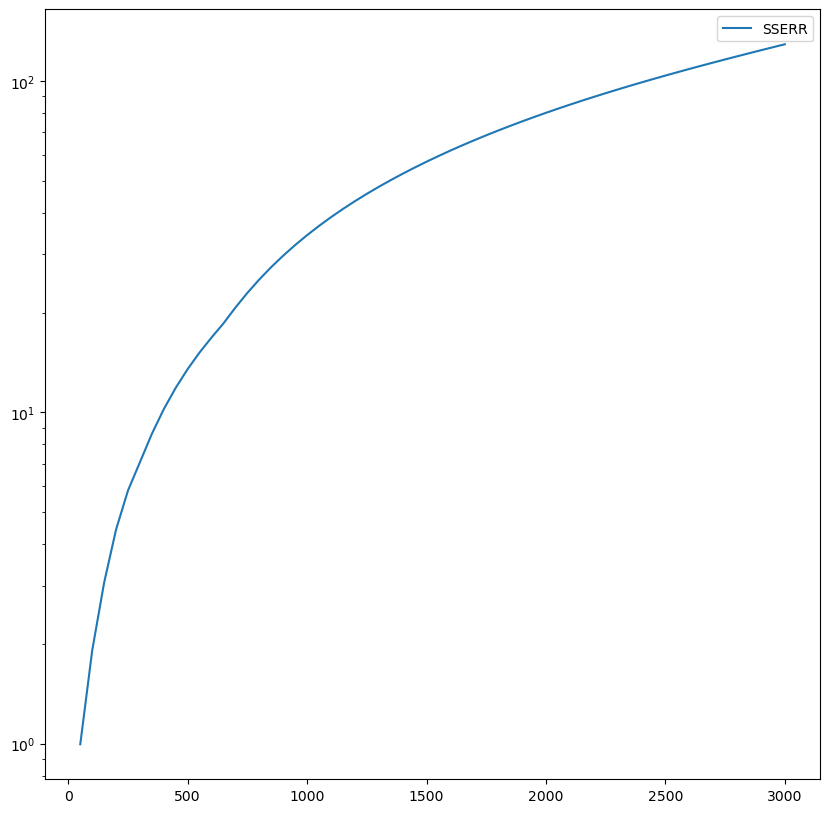

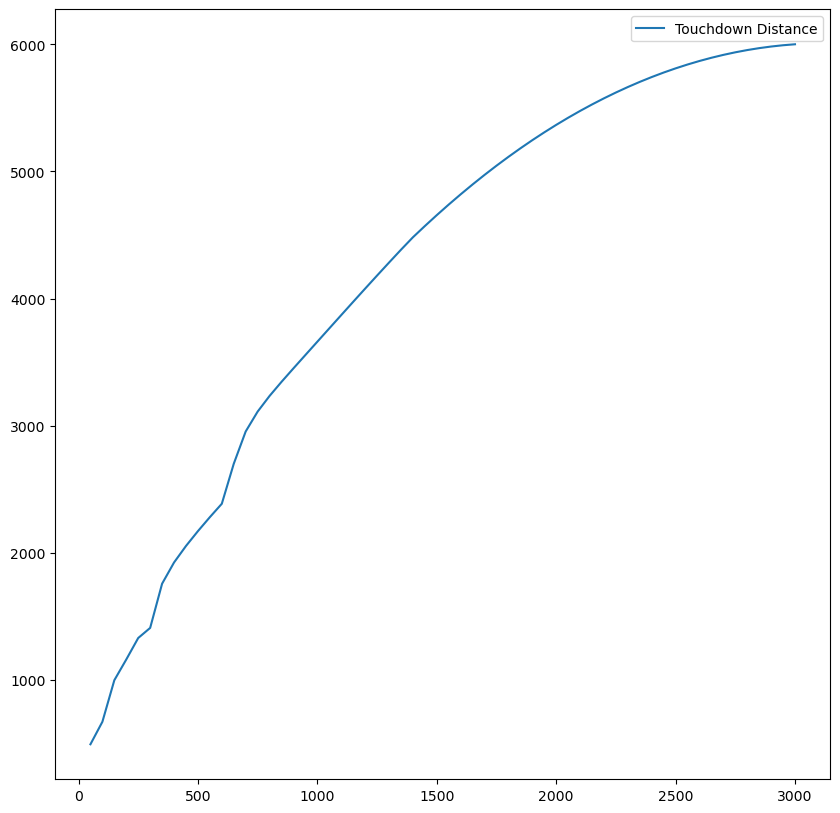

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.plot(dataframe["wl_depth"], dataframe["impact_criterion"], label="Impact Criterion")
plt.plot(dataframe["wl_depth"], dataframe["coupled_criterion"], label="Coupled Criterion")
# plot vertical lines at the end of each layer
for i, height in enumerate(heights):
    plt.axvline(x=height, color="black", linestyle="--")
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(dataframe["wl_depth"], dataframe["sserr_result"], label="SSERR")
plt.yscale("log")
# plt.ylim(0, 4000)
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(dataframe["wl_depth"], dataframe["touchdown_distance"], label="Touchdown Distance")
plt.legend()
plt.show()